<h2 align='center'>| Audio Classification using STFTSpectrogram Layer |</h2>

In [11]:
# Setting up the environment and importing necessary libraries

import os
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io.wavfile
from keras import layers
from scipy.signal import resample
import tensorflow as tf

os.environ["KERAS_BACKEND"] = "jax"
keras.utils.set_random_seed(41)

In [2]:
BASE_DATA_DIR = "H:/Audio Data Analysis/Audio Data Deep Learning Projects/Audio Classification using STFTSpectrogram Layer/ESC-50-master"
BATCH_SIZE = 16
NUM_CLASSES = 10
EPOCHS = 200
SAMPLE_RATE = 16000

### Read the CSV file

In [3]:
pd_data = pd.read_csv(os.path.join(BASE_DATA_DIR, "meta", "esc50.csv"))
# filter ESC-50 to ESC-10 and reassign the targets
pd_data = pd_data[pd_data["esc10"]]
targets = sorted(pd_data["target"].unique().tolist())
assert len(targets) == NUM_CLASSES
old_target_to_new_target = {old: new for new, old in enumerate(targets)}
pd_data["target"] = pd_data["target"].map(lambda t: old_target_to_new_target[t])
pd_data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
24,1-116765-A-41.wav,1,9,chainsaw,True,116765,A
54,1-17150-A-12.wav,1,4,crackling_fire,True,17150,A
55,1-172649-A-40.wav,1,8,helicopter,True,172649,A
...,...,...,...,...,...,...,...
1876,5-233160-A-1.wav,5,1,rooster,True,233160,A
1888,5-234879-A-1.wav,5,1,rooster,True,234879,A
1889,5-234879-B-1.wav,5,1,rooster,True,234879,B
1894,5-235671-A-38.wav,5,7,clock_tick,True,235671,A


### Defining functions to read and preprocess the .wav files

In [4]:
def read_wav_file(path, target_sr=SAMPLE_RATE):
    sr, wav = scipy.io.wavfile.read(os.path.join(BASE_DATA_DIR, "audio", path))
    wav = wav.astype(np.float32) / 32768.0  # normalize to [-1, 1]
    num_samples = int(len(wav) * target_sr / sr)  # resample to 16 kHz
    wav = resample(wav, num_samples)
    return wav[:, None]  # Add a channel dimension (of size 1)

#### Create a function that uses the STFTSpectrogram to compute a spectrogram, then plots it.

In [12]:
def plot_single_spectrogram(sample_wav_data, sample_rate):
    # Compute the spectrogram
    spectrogram = layers.STFTSpectrogram(
        mode="log",
        frame_length=sample_rate * 20 // 1000,
        frame_step=sample_rate * 5 // 1000,
        fft_length=1024,
        trainable=False,
    )(sample_wav_data[None, ...])[0, ...]
    
    # Transpose the spectrogram for plotting
    spectrogram = tf.transpose(spectrogram)
    
    # Plot the spectrogram
    plt.imshow(spectrogram.numpy(), origin="lower", aspect="auto", cmap="viridis")
    plt.title("Single Channel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(label="Log Magnitude")
    plt.show()

#### Create a function that uses the STFTSpectrogram to compute a spectrogram with multiple bandwidths, then plots it.

In [6]:
def plot_multi_bandwidth_specctrogram(sample_wav_data):
    spectrograms = np.concatenate(
        [
            layers.STFTSpectrogram(
                mode="log",
                frame_length=SAMPLE_RATE * x // 1000,
                frame_step=SAMPLE_RATE * 5 // 1000,
                fft_length=1024,
                padding="same",
                expand_dims=True,
            )(sample_wav_data[None, ...])[0, ...]
            for x in [5, 10, 20]
        ],
        axis=-1,
    ).transpose([1, 0, 2])

    mn = spectrograms.min(axis=(0,1), keepdims=True)
    mx = spectrograms.max(axis=(0,1), keepdims=True)
    spectrograms = (spectrograms - mn) / (mx - mn)

    plt.imshow(spectrograms, origin="lower")
    plt.title("Multi-bandwidth Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

#### Demonstrate a sample wav file

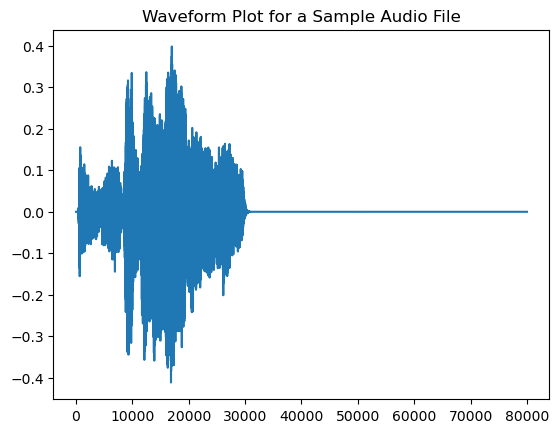

In [8]:
sample_wav_data = read_wav_file(pd_data["filename"].tolist()[52])
plt.plot(sample_wav_data[:, 0])
plt.title('Waveform Plot for a Sample Audio File')
plt.show()

#### Plotting a Spectrogram

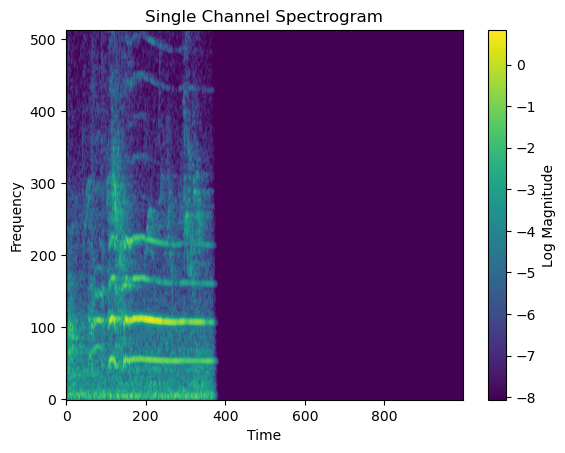

In [14]:
plot_single_spectrogram(sample_wav_data, sample_rate=16000)

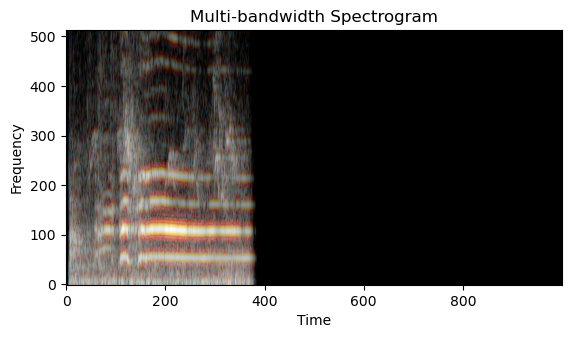

In [15]:
plot_multi_bandwidth_specctrogram(sample_wav_data)